## Getting the data

In [4]:
import pandas  as pd
import numpy as np

In [5]:
wiki_data = pd.read_csv('raw_data/page_data.csv')
pop_data = pd.read_csv('raw_data/WPDS_2018_data.csv')

In [6]:
wiki_data.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [7]:
pop_data.head()

,Geography,Population mid-2018 (millions)
0,AFRICA,"1,284"
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2


Renaming the Population column

In [8]:
pop_data = pop_data.rename({'Population mid-2018 (millions)': 'population'}, axis=1)

In [9]:
pop_data.head()

,Geography,population
0,AFRICA,"1,284"
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2


## Combining the dataset

Doing an inner joing to ensure that any non-matching rows are dropped.

In [10]:
comb = pd.merge(wiki_data, pop_data, left_on='country', right_on='Geography',
               how='inner').drop('Geography', axis=1)

In [11]:
comb.head()

,page,country,rev_id,population
0,Template:ZambiaProvincialMinisters,Zambia,235107991,17.7
1,Gladys Lundwe,Zambia,757566606,17.7
2,Mwamba Luchembe,Zambia,764848643,17.7
3,Thandiwe Banda,Zambia,768166426,17.7
4,Sylvester Chisembele,Zambia,776082926,17.7


In [12]:
comb.isnull().any()

page          False
country       False
rev_id        False
population    False
dtype: bool

## Getting Article Quality Predictions

This section of code is heavily borrowed from the example repository that explains how to use the Wikipedia ORES (Object Revision Evaluation Service) API to get ORES scores. Link: https://github.com/Ironholds/data-512-a2/blob/master/hcds-a2-bias_demo.ipynb

In [13]:
import requests
import json

# Define the endpoint
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'

# Specify the parameters
params = {'project' : 'enwiki',
          'model'   : 'wp10'
         }

headers = {
    'User-Agent' : 'https://github.com/whamsy', 
    'From' : 'whamsy@uw.edu'
}

def get_ores_data(revision_ids, headers):
    # smushing all the revision IDs together separated by | marks.
    params['revids'] = '|'.join(str(x) for x in revision_ids)
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    scores = response['enwiki']['scores']
    
    final_scores = []
    
    for score in scores:
        try:
            final_scores.append(scores[score]['wp10']['score']['prediction'])
        except KeyError:
            final_scores.append('no_score')
    
    return final_scores

Now that we have a function that can take a list of revision ids and return the ORES predictions, we can go ahead and apply it our comb dataset.

In [14]:
# Converting the list of revision_ids into chunks of 140

chunks = []

rev_ids = comb.rev_id.tolist()
for i in range(0, len(rev_ids), 140):
    chunks.append(rev_ids[i:i + 140])

In [15]:
from tqdm import tqdm

In [16]:
quality_predictions = [(get_ores_data(chunk, headers)) for chunk in tqdm(chunks)]

100%|██████████| 322/322 [01:49<00:00,  2.90it/s]


Now we have a list of lists, which we flatten to a single list of all preds. (Source: https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python)

In [17]:
final_preds = [single_pred for chunk in quality_predictions 
               for single_pred in chunk]

In [18]:
#check size match
len(final_preds) == len(rev_ids)

True

In [19]:
#adding the predictions to df
comb['article_quality'] = final_preds

In [20]:
comb.head()

,page,country,rev_id,population,article_quality
0,Template:ZambiaProvincialMinisters,Zambia,235107991,17.7,no_score
1,Gladys Lundwe,Zambia,757566606,17.7,Stub
2,Mwamba Luchembe,Zambia,764848643,17.7,Stub
3,Thandiwe Banda,Zambia,768166426,17.7,Stub
4,Sylvester Chisembele,Zambia,776082926,17.7,Stub


In [21]:
comb = comb.rename({'page':'article_name',
            'rev_id': 'revision_id'}, axis=1)

In [22]:
#rearrange order of columns

cols2 = ['country','article_name','revision_id', 'article_quality','population']
comb = comb[cols2]
comb.head()

,country,article_name,revision_id,article_quality,population
0,Zambia,Template:ZambiaProvincialMinisters,235107991,no_score,17.7
1,Zambia,Gladys Lundwe,757566606,Stub,17.7
2,Zambia,Mwamba Luchembe,764848643,Stub,17.7
3,Zambia,Thandiwe Banda,768166426,Stub,17.7
4,Zambia,Sylvester Chisembele,776082926,Stub,17.7


Belatedly, while analysis below realized that population has strings with ',' so replacing those and converting to float

In [23]:
comb.population = comb.population.str.replace(',', '').astype(float)

In [24]:
#exporting to csv
comb.to_csv('final_data.csv')

## Analysis

In order to produce the requisite tables, am using the data to derive stats that can then be easily used.

In [25]:
final_raw = comb

In [26]:
final_raw.head()

,country,article_name,revision_id,article_quality,population
0,Zambia,Template:ZambiaProvincialMinisters,235107991,no_score,17.7
1,Zambia,Gladys Lundwe,757566606,Stub,17.7
2,Zambia,Mwamba Luchembe,764848643,Stub,17.7
3,Zambia,Thandiwe Banda,768166426,Stub,17.7
4,Zambia,Sylvester Chisembele,776082926,Stub,17.7


In [27]:
#setting warning off, expected behavior
pd.options.mode.chained_assignment = None  # default='warn'

final_raw['num_articles'] = final_raw.groupby('country').transform('count').article_name
final_raw['high_quality'] = (final_raw['article_quality'] == 'GA') | (final_raw['article_quality'] == 'FA')

In [28]:
final_raw.head()

,country,article_name,revision_id,article_quality,population,num_articles,high_quality
0,Zambia,Template:ZambiaProvincialMinisters,235107991,no_score,17.7,26,False
1,Zambia,Gladys Lundwe,757566606,Stub,17.7,26,False
2,Zambia,Mwamba Luchembe,764848643,Stub,17.7,26,False
3,Zambia,Thandiwe Banda,768166426,Stub,17.7,26,False
4,Zambia,Sylvester Chisembele,776082926,Stub,17.7,26,False


We dont need the revision_id or article_name at this point.

In [29]:
final_raw = final_raw.drop(['article_name','revision_id'], axis=1)

In [30]:
#grouping-by common attributes to get the % of high quality articles)
final_raw = final_raw.groupby(['country','population','num_articles']).mean().reset_index()
final_raw.head()

,country,population,num_articles,high_quality
0,Afghanistan,36.50,327,0.018349
1,Albania,2.90,460,0.008696
2,Algeria,42.70,119,0.008403
3,Andorra,0.08,34,0.000000
4,Angola,30.40,110,0.036364


In [31]:
#converting population to millions
final_raw.loc[:,'population'] *= 1000000
final_raw.head()

,country,population,num_articles,high_quality
0,Afghanistan,36500000.0,327,0.018349
1,Albania,2900000.0,460,0.008696
2,Algeria,42700000.0,119,0.008403
3,Andorra,80000.0,34,0.000000
4,Angola,30400000.0,110,0.036364


In [32]:
final_raw['article_pop_ratio'] = (final_raw.num_articles * 100) / final_raw.population
final_raw['article_quality_ratio'] = 100 * final_raw.high_quality

In [33]:
final_raw.head()

,country,population,num_articles,high_quality,article_pop_ratio,article_quality_ratio
0,Afghanistan,36500000.0,327,0.018349,0.000896,1.834862
1,Albania,2900000.0,460,0.008696,0.015862,0.869565
2,Algeria,42700000.0,119,0.008403,0.000279,0.840336
3,Andorra,80000.0,34,0.000000,0.042500,0.000000
4,Angola,30400000.0,110,0.036364,0.000362,3.636364


In [34]:
import matplotlib as plt

### 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [35]:
%matplotlib inline

top_10_pop_art = final_raw[['country','population','article_pop_ratio']].sort_values('article_pop_ratio',ascending=False).head(10)
top_10_pop_art

,country,population,article_pop_ratio
166,Tuvalu,10000.0,0.550000
115,Nauru,10000.0,0.530000
135,San Marino,30000.0,0.273333
108,Monaco,40000.0,0.100000
93,Liechtenstein,40000.0,0.072500
161,Tonga,100000.0,0.063000
103,Marshall Islands,60000.0,0.061667
68,Iceland,400000.0,0.051500
3,Andorra,80000.0,0.042500
52,Federated States of Micronesia,100000.0,0.038000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116e8e898>],
      dtype=object)

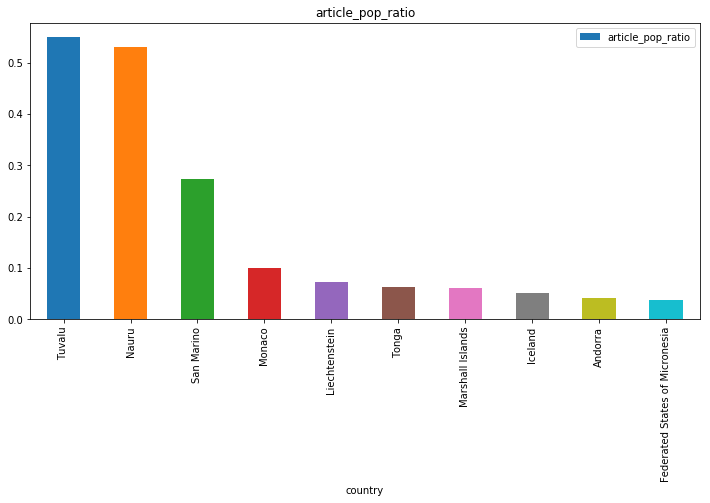

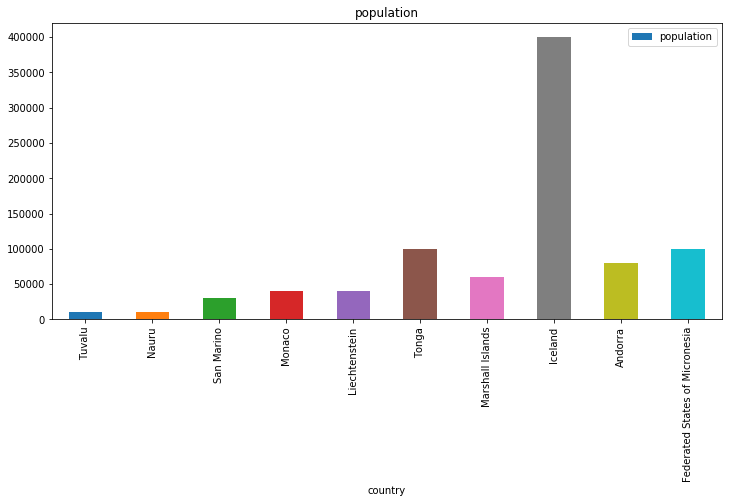

In [36]:
top_10_pop_art.plot.bar(x='country', y='article_pop_ratio', subplots=True, layout=(2,1), figsize=(12,12))
top_10_pop_art.plot.bar(x='country', y='population', subplots=True, layout=(2,1), figsize=(12,12))

### 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [37]:
bottom_10_pop_art = final_raw[['country','population','article_pop_ratio']].sort_values('article_pop_ratio').head(10)
bottom_10_pop_art

,country,population,article_pop_ratio
69,India,1.371300e+09,0.000072
70,Indonesia,2.652000e+08,0.000081
34,China,1.393800e+09,0.000082
173,Uzbekistan,3.290000e+07,0.000088
51,Ethiopia,1.075000e+08,0.000098
178,Zambia,1.770000e+07,0.000147
82,"Korea, North",2.560000e+07,0.000152
159,Thailand,6.620000e+07,0.000169
13,Bangladesh,1.664000e+08,0.000195
112,Mozambique,3.050000e+07,0.000197


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117628f98>],
      dtype=object)

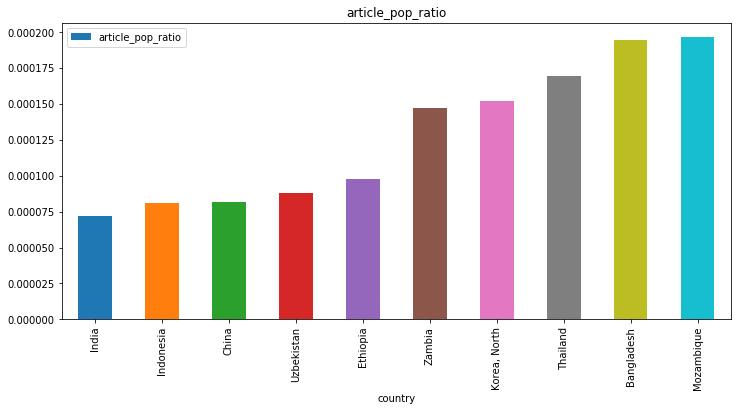

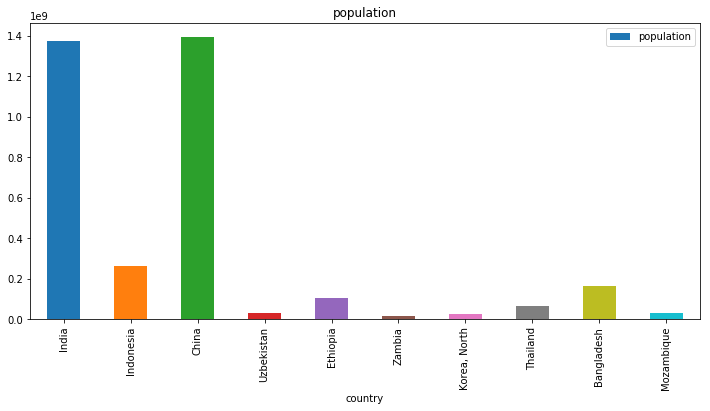

In [38]:
bottom_10_pop_art.plot.bar(x='country', y='article_pop_ratio', subplots=True, layout=(2,1), figsize=(12,12))
bottom_10_pop_art.plot.bar(x='country', y='population', subplots=True, layout=(2,1), figsize=(12,12))

### 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [39]:
top_10_art_quality = final_raw[['country','population','article_quality_ratio']].sort_values('article_quality_ratio',ascending=False).head(10)
top_10_art_quality

,country,population,article_quality_ratio
84,Kosovo,1800000.0,14.583333
50,Estonia,1300000.0,12.418301
103,Marshall Islands,60000.0,10.810811
105,Mauritius,1300000.0,10.294118
18,Benin,11500000.0,9.574468
12,Bahrain,1500000.0,9.523810
48,Equatorial Guinea,1300000.0,9.375000
19,Bhutan,800000.0,9.090909
177,Yemen,28900000.0,9.016393
86,Kyrgyzstan,6100000.0,8.333333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1178a8668>],
      dtype=object)

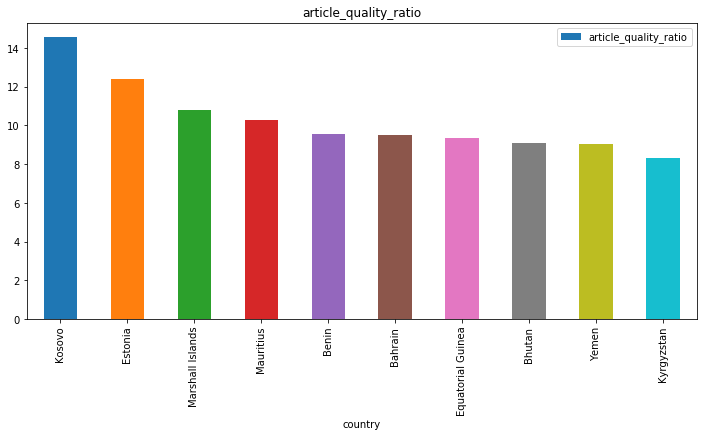

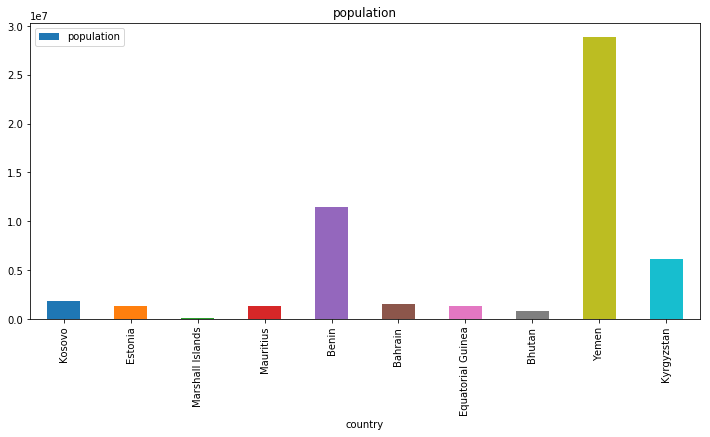

In [40]:
top_10_art_quality.plot.bar(x='country', y='article_quality_ratio', subplots=True, layout=(2,1), figsize=(12,12))
top_10_art_quality.plot.bar(x='country', y='population', subplots=True, layout=(2,1), figsize=(12,12))

### 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [41]:
bottom_10_art_quality = final_raw[['country','population','article_quality_ratio']].sort_values('article_quality_ratio').head(10)
bottom_10_art_quality

,country,population,article_quality_ratio
179,Zimbabwe,14000000.0,0.0
144,Slovenia,2100000.0,0.0
36,Comoros,800000.0,0.0
43,Djibouti,1000000.0,0.0
44,Dominica,70000.0,0.0
45,Dominican Republic,10800000.0,0.0
49,Eritrea,6000000.0,0.0
138,Senegal,16300000.0,0.0
136,Sao Tome and Principe,200000.0,0.0
53,Fiji,900000.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117943198>],
      dtype=object)

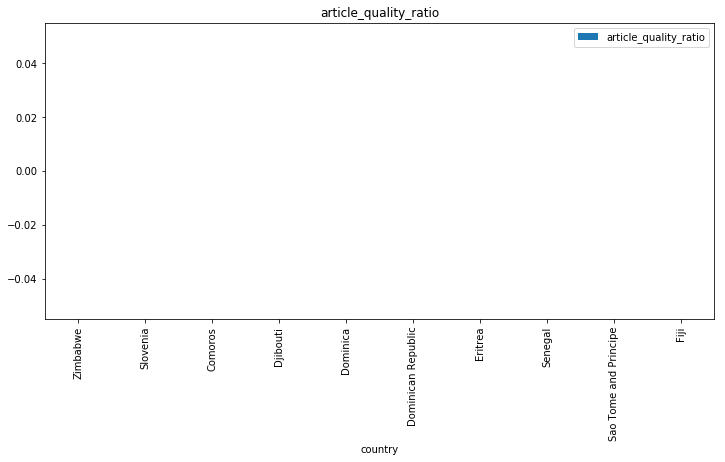

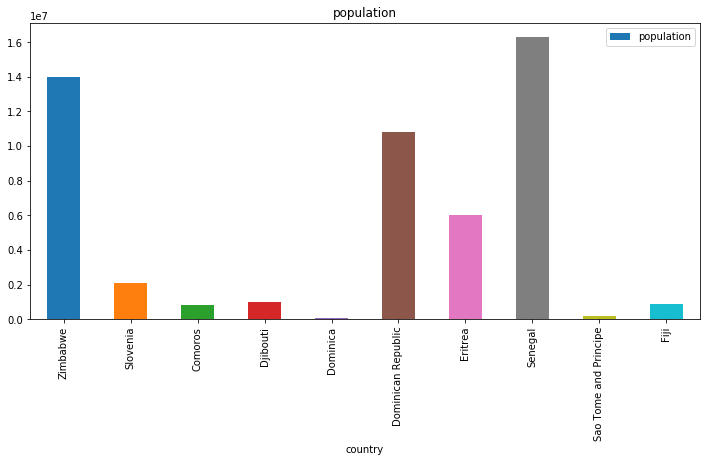

In [42]:
bottom_10_art_quality.plot.bar(x='country', y='article_quality_ratio', subplots=True, layout=(2,1), figsize=(12,12))
bottom_10_art_quality.plot.bar(x='country', y='population', subplots=True, layout=(2,1), figsize=(12,12))